In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import sys; sys.path.insert(0, '..')
import utils

class FourSplit(Model):
    def __init__(self, n_enc, latent_dim, io_shape):
        super(FourSplit, self).__init__()
        n_filters = [32, 64]
        n_enc_1d = n_enc**(1/2)
        enc_input_shape = (n_enc, int(io_shape[0]//n_enc_1d), int(io_shape[1]//n_enc_1d), io_shape[2])
        self.encoder = self._create_encoder(latent_dim//n_enc, enc_input_shape[1:], n_filters)
        self.input_reshaper = utils.Reshaper(enc_input_shape, enc_input_shape[1:])
        self.latent_reshaper = utils.Reshaper([latent_dim//n_enc], [latent_dim])
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        self.compile()

    def encode(self, x):
        return self.encoder( self.input_reshaper(x) )
    
    def decode(self, z):
        return self.decoder( self.latent_reshaper(z) )
        
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid'),
            Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='relu', padding='valid'),
            Flatten(),
            Dense(latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def reco_loss(self, x_in, x_truth):
        z = self.encode(x_in)
        x_pred = self.decode(z)
        err = tf.reduce_mean(tf.square(tf.subtract(x_pred, x_truth)))
        return err

In [2]:
import tensorflow as tf

@tf.function
def train_step(model, x_in, x_truth, optimizer):
    with tf.GradientTape() as tape:   # tf.Variables inside are tracked
        loss = model.reco_loss(x_in, x_truth)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [4]:
import time
from keras.optimizers import Adam
from keras.metrics import Mean
import numpy as np

optimizer = Adam(1e-4)
BATCH_SIZE = 32

LATENT_DIM = 16
N_ENC = 4
IO_SHAPE = (28,28,1)

train_data, test_data = utils.gen_data(N_ENC, BATCH_SIZE)
model = FourSplit(N_ENC, LATENT_DIM, IO_SHAPE)

# train_losses, test_losses = [], []
# for epoch in range(1, 31):
#     start_time = time.time()
    
#     # Train
#     train_loss = Mean()
#     for i, (x_in, x_truth, y_truth) in enumerate(train_data):
#         train_loss(train_step(model, x_in, x_truth, optimizer))
#     train_losses.append(train_loss.result())
    
#     # Test
#     test_loss = Mean()
#     for i, (x_in, x_truth, y_truth) in enumerate(test_data):
#         test_loss(model.reco_loss(x_in, x_truth))
#     test_losses.append(test_loss.result())
    
#     end_time = time.time()
#     delta = round(end_time - start_time, 1)
#     print("Epoch {:2d} || train loss: {:.5f} | test loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], test_losses[epoch-1], delta))

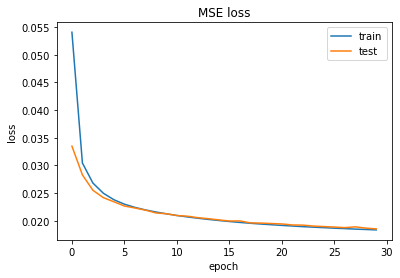

In [4]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('MSE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

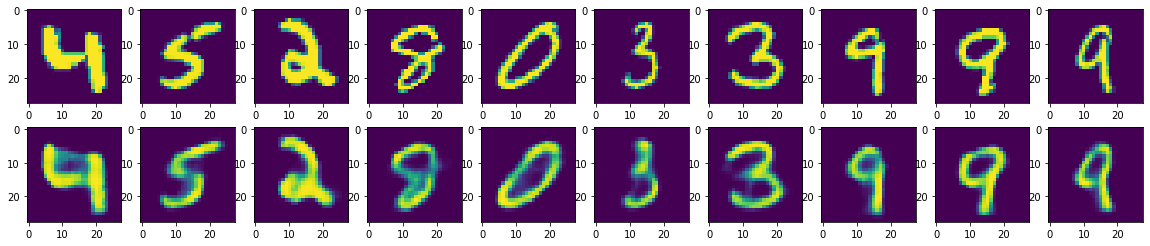

In [7]:
import matplotlib.pyplot as plt

n_samples = 10
plt.figure(figsize=(20,4))

for i, (x_in, x_truth, _) in enumerate(test_data.take(1)):
    x_pred = model.decode(model.encode(x_in))

    for j in range(n_samples):
        ax = plt.subplot(2, n_samples, j+1)
        plt.imshow(tf.reshape(x_truth[j], (28, 28)))
        
        ax = plt.subplot(2, n_samples, n_samples+j+1)
        plt.imshow(tf.reshape(x_pred[j], (28, 28)))

In [6]:
# model.encoder.save_weights('../weights/14_4split_encoder.h5')
# model.decoder.save_weights('../weights/14_4split_decoder.h5')

model.encoder.load_weights('../weights/14_4split_encoder.h5')
model.decoder.load_weights('../weights/14_4split_decoder.h5')

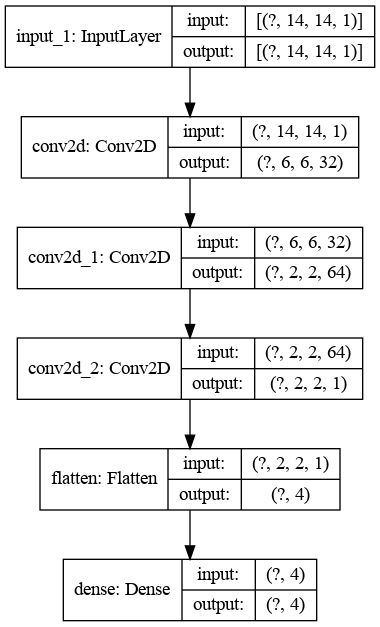

In [10]:
from keras.utils import plot_model
# plot_model(model, to_file='../img/00_CAE16_model.png', show_shapes=True, expand_nested=True)
plot_model(model.encoder, show_shapes=True, expand_nested=True)